# Vehicle Detection
The goal of this project is to build a pipeline that detects vehicles in a video (to simulate detecting vehicles while on the road).

The pipeline includes:

The pipeline is demonstrated on six test images.

In [1]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

test_image_file_names = glob.glob('./test_images/test*.jpg')
num_images = len(test_image_file_names)

In [2]:
images = []
for idx, test_image_file_name in enumerate(test_image_file_names):
    image = mpimg.imread(test_image_file_name)
    images.append(image)
num_channels = images[0].shape[2]

## Extract HOG features of each image
The histogram of gradients is extracted from each image.  The image is first grayscaled then run through scikit-image's [hog](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog) function.

The histogram of gradients acts as a "fingerprint" to the image. Images with cars will share a similar fingerprint.

In [3]:
from skimage import color
from skimage.feature import hog

def extract_hog_features(image, num_orients, pixels_per_cell, cells_per_block, return_hog_img=True, return_feature_vec=True):
    grayscale_img = color.rgb2gray(image)
    return hog(grayscale_img, orientations=num_orients, pixels_per_cell=(pixels_per_cell, pixels_per_cell), cells_per_block=(cells_per_block, cells_per_block), block_norm='L2', visualise=return_hog_img)

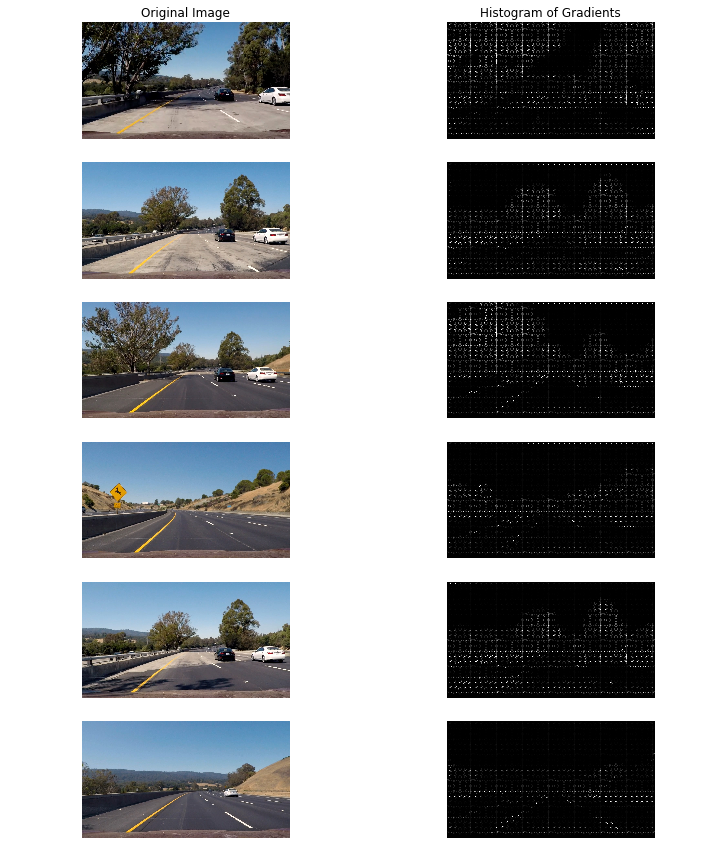

In [9]:
from skimage import exposure

num_orientations = 9
pixels_per_cell = 32
cells_per_block = 1

fig, axarr = plt.subplots(num_images, 2, figsize=(12, 15), sharey=True)
axarr[0, 0].set_title('Original Image')
axarr[0, 1].set_title('Histogram of Gradients')

for idx, image in enumerate(images):
    histo_of_grads, hog_img = extract_hog_features(image, num_orientations, pixels_per_cell, cells_per_block, return_feature_vec=False)

    # Rescale histogram for better display
    hog_img = exposure.rescale_intensity(hog_img, in_range=(0, 0.02))

    axarr[idx, 0].imshow(image)
    axarr[idx, 1].imshow(hog_img, cmap='gray')
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')
plt.show()

# Color Histogram Features

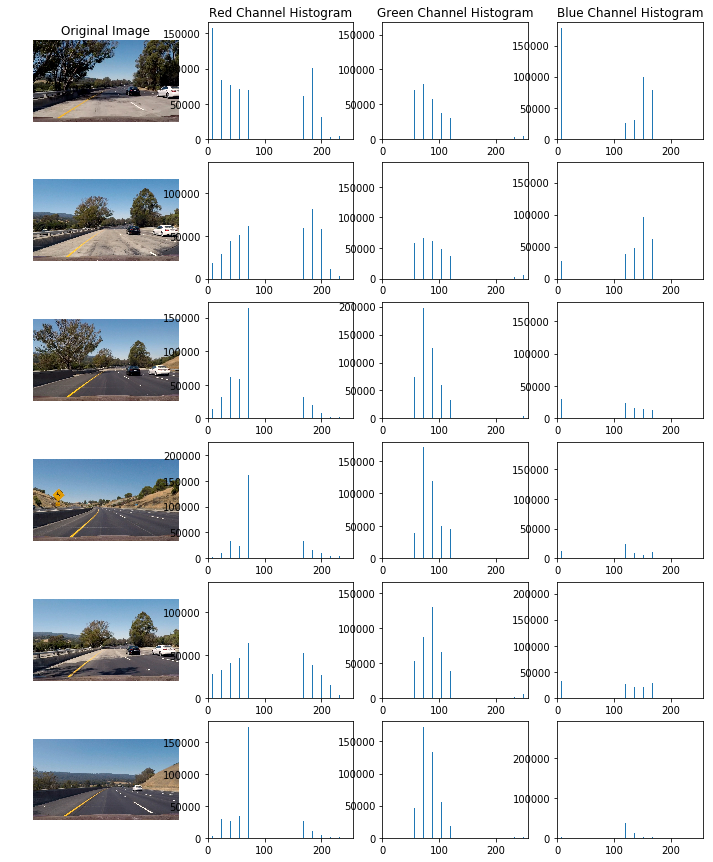

In [10]:
def get_color_histograms(img):
    histograms = []
    for channel_idx in range(num_channels):
        channel = img[:, :, channel_idx]
        channel_histogram = np.histogram(channel, bins=16, range=(0, 256))
        histograms.append(channel_histogram)
    return histograms


def extract_color_histogram_features(img):
    histogram_data = get_color_histograms(img)
    feature_vector = []
    for channel_idx in range(img.shape[2]):
        histogram = histogram_data[channel_idx][0]
        feature_vector = np.concatenate((feature_vector, histogram))
    return feature_vector


fig, axarr = plt.subplots(num_images, num_channels+1, figsize=(12, 15))
axarr[0, 0].set_title('Original Image')
axarr[0, 1].set_title('Red Channel Histogram')
axarr[0, 2].set_title('Green Channel Histogram')
axarr[0, 3].set_title('Blue Channel Histogram')

color_histogram_feature_vector = []
for idx, image in enumerate(images):
    histogram_data = get_color_histograms(image) # get color histograms used to plot data

    R_histogram = histogram_data[0][0]
    G_histogram = histogram_data[1][0]
    B_histogram = histogram_data[2][0]
    bin_edges = histogram_data[0][1]
    bin_centers = (bin_edges[1:] + bin_edges[0:-1])/2

    color_histogram_feature_vector.append(np.concatenate((R_histogram, G_histogram, B_histogram)))

    # Plot Data
    bin_centers = (bin_edges[1:] + bin_edges[0:-1])/2
    axarr[idx, 0].imshow(image)
    axarr[idx, 0].axis('off')
    
    for j, histogram_datum in enumerate(histogram_data):
        histogram = histogram_datum[0]
        axarr[idx, j+1].bar(bin_centers, histogram)
        axarr[idx, j+1].set_xlim(0, 256)
plt.show()

# Train Classifier

In [18]:
def extract_all_features(img):
    hog_features = extract_hog_features(image, num_orientations, pixels_per_cell, cells_per_block, return_hog_img=False)
    color_hist_features = extract_color_histogram_features(img)
    features = np.concatenate((hog_features, color_hist_features))
    return features

car_paths = glob.glob('./vehicles_smallset/**/*.jpeg')
notcar_paths = glob.glob('./non-vehicles_smallset/**/*.jpeg')
print("There are {} car images.".format(len(car_paths)))
print("There are {} non-car images".format(len(notcar_paths)))

car_features = []
for car_path in car_paths:
    car_img = mpimg.imread(car_path)
    single_car_features = extract_all_features(car_img)
    car_features.append(single_car_features)

not_car_features = []
for notcar_path in notcar_paths:
    notcar_img = mpimg.imread(notcar_path)
    single_notcar_features = extract_all_features(notcar_img)
    not_car_features.append(single_notcar_features)

There are 1196 car images.
There are 1125 non-car images


In [20]:
from sklearn.preprocessing import StandardScaler

X = np.concatenate((car_features, not_car_features))
print(X.shape)

scaled_X = StandardScaler().fit_transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))


(2321, 7968)
(2321, 7968)


In [21]:
# Save scaled_X and y
from sklearn.externals import joblib
joblib.dump(scaled_X, 'scaled_X.pkl')
joblib.dump(y, 'y.pkl')

['y.pkl']

In [22]:
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time

if 'scaled_X' not in locals():
    scaled_X = joblib.load('scaled_X.pkl')
if 'y' not in locals():
    y = joblib.load('y.pkl')

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

21.2 Seconds to train SVC...
Test Accuracy of SVC =  0.9634


# Sliding Windows Implementation
Each image (or video frame) is scanned for vehicles.  If a vehicle is detected, a bounding box will be drawn around it.

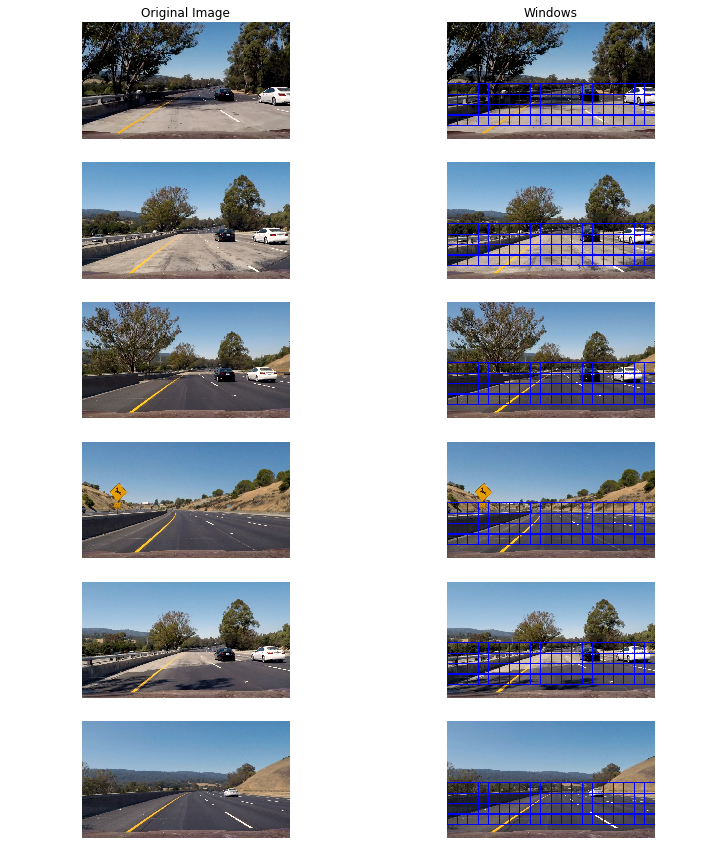

In [39]:
import cv2

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

fig, axarr = plt.subplots(num_images, 2, figsize=(12, 15), sharey=True)
axarr[0, 0].set_title('Original Image')
axarr[0, 1].set_title('Windows')

y_start_stop = [380, 650]
# Show working sliding windows function
for idx, image in enumerate(images):
    windows = slide_window(image, y_start_stop=y_start_stop)
    windows_img = draw_boxes(image, windows)
    axarr[idx, 0].imshow(image)
    axarr[idx, 1].imshow(windows_img)
    axarr[idx, 0].axis('off')
    axarr[idx, 1].axis('off')
plt.show()